# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Partial Dependence, Individual Conditional Expectation, and Surrogate Models

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks.

In [ ]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,22 mins 59 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,1 month and 21 days
H2O cluster name:,H2O_from_python_ngill_1gewar
H2O cluster total nodes:,1
H2O cluster free memory:,1.259 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


# Dataset with Known Signal Generating Functions

Create dataset with a known signal generating function with noise: 

$$ y = x_1 * x_4 + |x_8| * (x_9)^2 + e $$

In this notebook we prevent XGBoost from overfitting to the known signal by providing a validation set.

# Data Generation and XGBoost Training

In [5]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function=True, noise=True)
rson = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


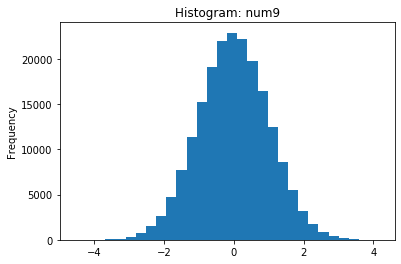

In [6]:
rson_pd = rson.as_data_frame()
_ = rson_pd['num9'].plot(kind='hist', bins=30, title='Histogram: num9')

In [7]:
y = 'target'
X = [name for name in rson.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [8]:
rson[y] = rson[y].asfactor()
train, valid, _ = rson.split_frame([0.4, 0.3], seed = 12345)
print(train.shape)
print(valid.shape)

(80049, 18)
(59947, 18)


In [9]:
rsontrain_pd = train.as_data_frame()
rsonvalid_pd = valid.as_data_frame()

In [10]:
rsontrain_dm = xgb.DMatrix(rsontrain_pd[X],
                           rsontrain_pd[y])
rsonvalid_dm = xgb.DMatrix(rsonvalid_pd[X],
                           rsonvalid_pd[y])

/Users/ngill/Desktop/xai_guidelines/xai_env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/ngill/Desktop/xai_guidelines/xai_env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
ave_y = rsontrain_pd['target'].mean()
print(ave_y)

0.42154180564404303


In [12]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsontrain_dm, 'train'), (rsonvalid_dm, 'eval')]

rson_model = xgb.train(params, 
                       rsontrain_dm, 
                       400,
                       early_stopping_rounds=50,
                       evals=watchlist, 
                       verbose_eval=True)

[0]	train-auc:0.686314	eval-auc:0.66464
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.775261	eval-auc:0.752746
[2]	train-auc:0.780624	eval-auc:0.754149
[3]	train-auc:0.803483	eval-auc:0.777096
[4]	train-auc:0.816312	eval-auc:0.79038
[5]	train-auc:0.816112	eval-auc:0.787877
[6]	train-auc:0.823822	eval-auc:0.796767
[7]	train-auc:0.823367	eval-auc:0.795818
[8]	train-auc:0.822771	eval-auc:0.794409
[9]	train-auc:0.828403	eval-auc:0.798933
[10]	train-auc:0.833688	eval-auc:0.802686
[11]	train-auc:0.837093	eval-auc:0.805717
[12]	train-auc:0.837705	eval-auc:0.805411
[13]	train-auc:0.840106	eval-auc:0.807929
[14]	train-auc:0.839334	eval-auc:0.806934
[15]	train-auc:0.838728	eval-auc:0.805815
[16]	train-auc:0.841577	eval-auc:0.807897
[17]	train-auc:0.842426	eval-auc:0.808025
[18]	train-auc:0.844033	eval-auc:0.810016
[19]	train-auc:0.845252	eval-auc:0.811741
[20]	train-auc:0.84623	eval-auc

[191]	train-auc:0.875383	eval-auc:0.822511
[192]	train-auc:0.875472	eval-auc:0.822525
[193]	train-auc:0.875578	eval-auc:0.822533
[194]	train-auc:0.875645	eval-auc:0.822582
[195]	train-auc:0.875667	eval-auc:0.822565
[196]	train-auc:0.875868	eval-auc:0.822567
[197]	train-auc:0.875947	eval-auc:0.822541
[198]	train-auc:0.876099	eval-auc:0.822545
[199]	train-auc:0.876118	eval-auc:0.822526
[200]	train-auc:0.876184	eval-auc:0.822534
[201]	train-auc:0.876425	eval-auc:0.822583
[202]	train-auc:0.876598	eval-auc:0.822644
[203]	train-auc:0.876693	eval-auc:0.822672
[204]	train-auc:0.876756	eval-auc:0.822613
[205]	train-auc:0.876812	eval-auc:0.82257
[206]	train-auc:0.876981	eval-auc:0.822599
[207]	train-auc:0.877015	eval-auc:0.822576
[208]	train-auc:0.877058	eval-auc:0.822561
[209]	train-auc:0.877118	eval-auc:0.8225
[210]	train-auc:0.877116	eval-auc:0.82248
[211]	train-auc:0.877124	eval-auc:0.822441
[212]	train-auc:0.877208	eval-auc:0.822445
[213]	train-auc:0.877283	eval-auc:0.822422
[214]	train-auc

[383]	train-auc:0.892387	eval-auc:0.823393
[384]	train-auc:0.892507	eval-auc:0.82342
[385]	train-auc:0.892545	eval-auc:0.823408
[386]	train-auc:0.892648	eval-auc:0.823405
[387]	train-auc:0.892744	eval-auc:0.823362
[388]	train-auc:0.892761	eval-auc:0.823382
[389]	train-auc:0.892844	eval-auc:0.823399
[390]	train-auc:0.892897	eval-auc:0.823396
[391]	train-auc:0.892966	eval-auc:0.823396
[392]	train-auc:0.893079	eval-auc:0.823424
[393]	train-auc:0.893152	eval-auc:0.823434
[394]	train-auc:0.893265	eval-auc:0.823427
[395]	train-auc:0.893363	eval-auc:0.823464
[396]	train-auc:0.893394	eval-auc:0.823464
[397]	train-auc:0.893502	eval-auc:0.823451
[398]	train-auc:0.893537	eval-auc:0.82347
[399]	train-auc:0.89365	eval-auc:0.823463


#### Function for calculating partial dependence

In [13]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [14]:
par_dep_num9 = par_dep('num9', rsonvalid_pd[X], rson_model)

In [15]:
par_dep_num9

,num9,partial_dependence
0,-4.080806,0.769547
1,-3.682671,0.769547
2,-3.284536,0.769547
3,-2.886401,0.773146
4,-2.488266,0.771257
5,-2.090131,0.712482
6,-1.691996,0.688156
7,-1.293861,0.579185
8,-0.895725,0.454450
9,-0.497590,0.299005


#### Bind XGBoost predictions to training data

In [16]:
rson_preds = pd.DataFrame(rson_model.predict(rsonvalid_dm))

In [17]:
rson_decile_frame = pd.concat([rsonvalid_pd, rson_preds], axis=1)
rson_decile_frame = rson_decile_frame.rename(columns={0: 'predict'})
rson_decile_hframe = h2o.H2OFrame(rson_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
rson_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.199012
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.838346
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,1,0.609780
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,1,0.126717
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,1,10,1,0.229028


#### Find percentiles of XGBoost predictions

In [19]:
rson_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rson_decile_hframe)

In [20]:
rson_percentile_dict

{0: 99600,
 99: 102609,
 10: 113549,
 20: 79889,
 30: 134668,
 40: 77368,
 50: 7841,
 60: 59441,
 70: 119213,
 80: 149213,
 90: 18466}

#### Calculate ICE curve values

In [21]:
# retreive bins from original partial dependence calculation
bins_num9 = list(par_dep_num9['num9'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(rson_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num9[col_name] = par_dep('num9', 
                                     rsonvalid_pd[rsonvalid_pd['row_id'] == int(rson_percentile_dict[i])][X], 
                                     rson_model, 
                                     bins=bins_num9)['partial_dependence']


#### Display partial dependence and ICE for num9

In [22]:
par_dep_num9

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.080806,0.769547,0.502995,0.860015,0.479742,0.769684,0.652353,0.441001,0.793332,0.827854,0.859479,0.905464,0.941879
1,-3.682671,0.769547,0.502995,0.860015,0.479742,0.769684,0.652353,0.441001,0.793332,0.827854,0.859479,0.905464,0.941879
2,-3.284536,0.769547,0.502995,0.860015,0.479742,0.769684,0.652353,0.441001,0.793332,0.827854,0.859479,0.905464,0.941879
3,-2.886401,0.773146,0.513301,0.862903,0.490997,0.771007,0.654920,0.443401,0.797306,0.833325,0.860574,0.907674,0.944214
4,-2.488266,0.771257,0.502363,0.870368,0.467290,0.749195,0.666068,0.427011,0.812800,0.838386,0.864992,0.903154,0.942852
5,-2.090131,0.712482,0.290301,0.865297,0.301699,0.554899,0.627756,0.294772,0.762871,0.819000,0.829017,0.893190,0.934170
6,-1.691996,0.688156,0.223516,0.859086,0.281312,0.446454,0.632475,0.243052,0.753896,0.834059,0.808405,0.884790,0.935669
7,-1.293861,0.579185,0.104319,0.761499,0.220331,0.250732,0.533801,0.172812,0.613453,0.781155,0.725528,0.838279,0.911323
8,-0.895725,0.454450,0.115723,0.422805,0.222980,0.195305,0.339286,0.160642,0.488821,0.588179,0.734333,0.772008,0.797308
9,-0.497590,0.299005,0.091634,0.173705,0.173266,0.148852,0.211613,0.123090,0.294362,0.192885,0.769622,0.263218,0.607718


#### Plot partial dependence and ICE

In [23]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


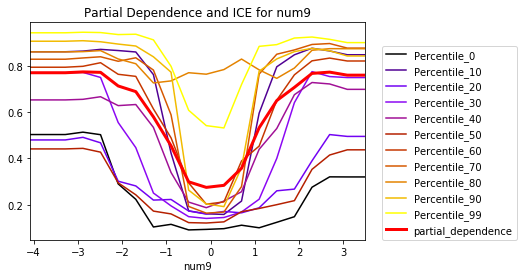

In [24]:
plot_par_dep_ICE('num9', par_dep_num9)

#### Train single h2o decision tree

In [25]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=5,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=rson_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/ngill/Desktop/xai_guidelines/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [26]:
# title for plot
title = 'Known Signal Data (with Validation) Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/ngill/Desktop/xai_guidelines/xai_env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/ngill/Desktop/xai_guidelines/xai_env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/ngill/Desktop/xai_guidelines/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Known Signal Data (with Validation) Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [27]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


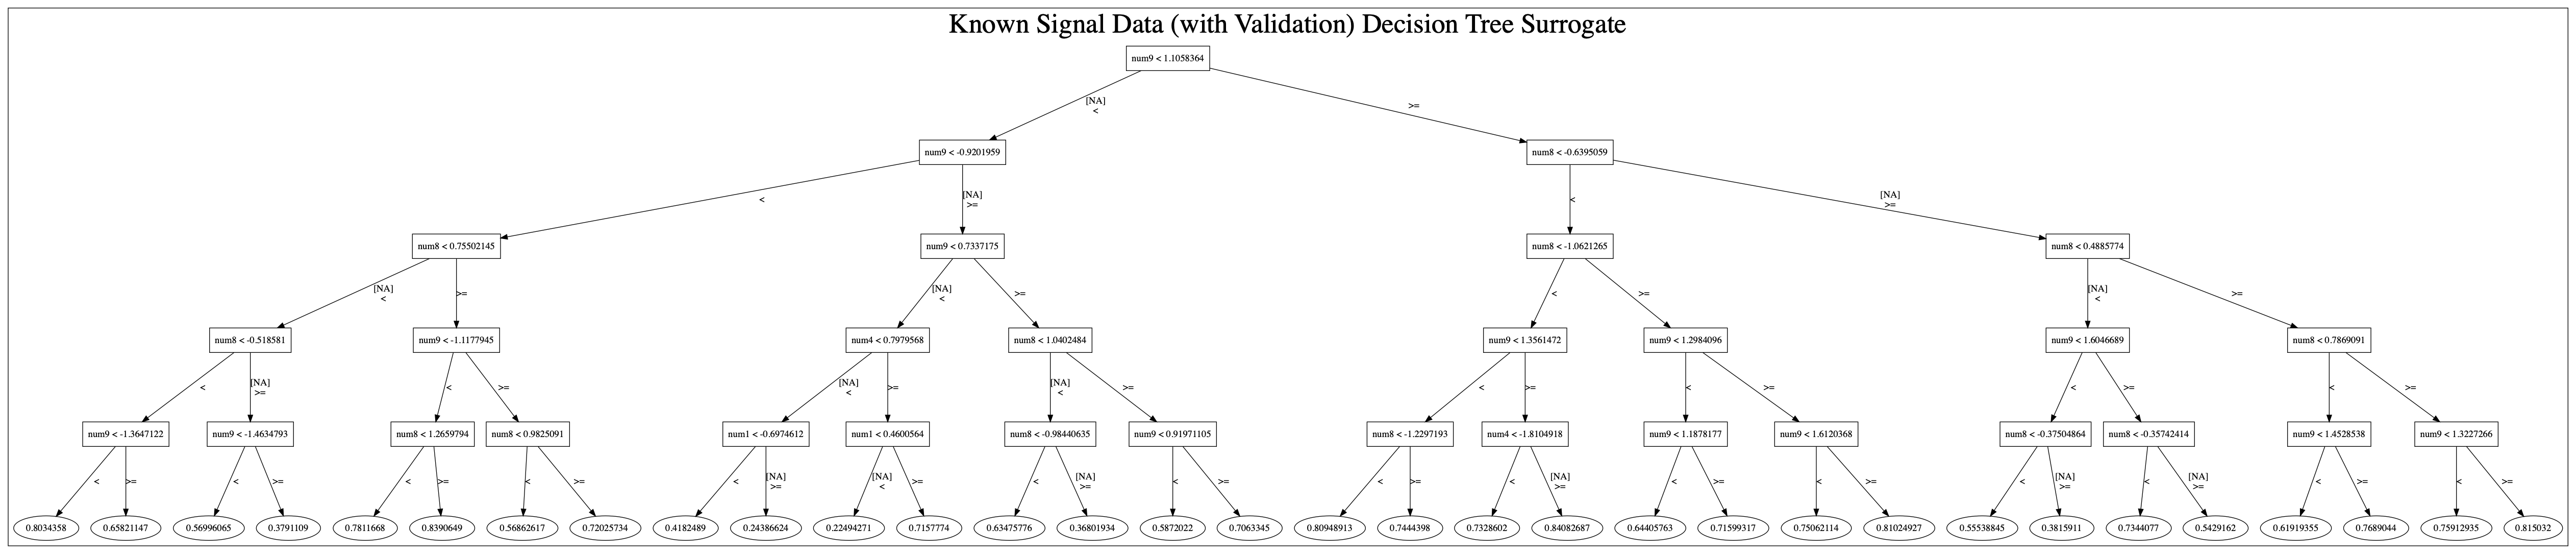

In [28]:
# display in-notebook
display(Image((png_file_name)))